### Import important libirarys

In [16]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gc # Garbage collector
import matplotlib.pyplot as plt
import time # For adding delay between steps
from env3 import TreasureHuntEnv


### Environment setup

In [35]:
env = TreasureHuntEnv(size=9, max_steps=500, lives=5, special_duration=20)

# def main():
#     """Main function to demonstrate the environment"""
#     # Create environment with human rendering mode
#     env = TreasureHuntEnv(size=9, max_steps=700, lives=8, render_mode='human')
    
#     # Reset environment to initialize
#     observation, info = env.reset()
    
#     # Run a simple random agent
#     total_reward = 0
#     done = False
#     while not done:
#         env.render()
#         # Random action (including the new COLLECT action)
#         action = env.action_space.sample()
        
#         # Step environment with the selected action
#         observation, reward, terminated, truncated, info = env.step(action)
#         total_reward += reward
#         done = terminated or truncated
        
#         # Sleep to slow down visualization
#         import time
#         time.sleep(0.3)
    
#     print(f"Episode finished with total reward: {total_reward}, Score: {info['score']}")
    
#     # Close environment and clean up
#     env.close()

# # Run the main function when script is executed directly
# main()

### Make balanced state representation

In [36]:
# Balanced state representation
def process_observation(obs):
    # Get grid and reshape to 2D to preserve spatial information
    grid = obs['grid'].reshape(env.size, env.size) / 5.0  # Normalize
    
    # Extract agent position and normalize
    agent_x, agent_y = obs['agent_pos']
    norm_x, norm_y = agent_x / env.size, agent_y / env.size
    
    # Additional useful features
    steps_normalized = obs['steps_left'] / env.max_steps
    lives_normalized = obs.get('lives', 3) / 3.0
    special_count = min(len(obs['special_treasures']), 3) / 3.0
    
    # Return the grid and feature vector separately
    return grid, np.array([norm_x, norm_y, steps_normalized, lives_normalized, special_count])


### Build DQN Model

In [ ]:
def build_balanced_dqn(grid_size, feature_size, action_size):
    # Input layers
    grid_input = Input(shape=(grid_size, grid_size), name='grid_input')
    feature_input = Input(shape=(feature_size,), name='feature_input')
    
    # Use Reshape layer instead of tf.expand_dims to avoid weak tensor error
    grid_reshaped = Reshape((grid_size, grid_size, 1))(grid_input)
    
    # CNN layers for spatial feature extraction
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(grid_reshaped)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool)
    
    # Flatten CNN output
    grid_flatten = Flatten()(conv3)
    
    # Process flattened CNN features with dense layer
    grid_dense = Dense(128, activation='relu')(grid_flatten)
    
    # Process additional features
    feature_dense = Dense(32, activation='relu')(feature_input)
    
    # Combine both pathways
    combined = Concatenate()([grid_dense, feature_dense])
    
    # Hidden layers
    hidden1 = Dense(128, activation='relu')(combined)
    hidden2 = Dense(64, activation='relu')(hidden1)
    
    # Output layer
    output = Dense(action_size, activation='linear')(hidden2)
    
    model = Model(inputs=[grid_input, feature_input], outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0003))
    
    return model


#### Experience Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def add(self, state_grid, state_features, action, reward, next_state_grid, next_state_features, done):
        self.memory.append((state_grid, state_features, action, reward, next_state_grid, next_state_features, done))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### Initialize hyperparameters and model setup 

In [39]:
grid_size = env.size
feature_size = 5
action_size = env.action_space.n
batch_size = 32
n_episodes = 200
gamma = 0.95
epsilon_start = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
update_target_frequency = 10 
max_memory = 10000
render_delay = 0.1 

memory = ReplayBuffer(max_memory)
model = build_balanced_dqn(grid_size, feature_size, action_size)
target_model = build_balanced_dqn(grid_size, feature_size, action_size)
target_model.set_weights(model.get_weights())

### Make action selection and target model update

In [40]:
def choose_action(state_grid, state_features, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    
    state_grid = state_grid[np.newaxis, :, :]
    state_features = state_features[np.newaxis, :]
    
    return np.argmax(model.predict([state_grid, state_features], verbose=0)[0])

def update_target_model():
    target_model.set_weights(model.get_weights())

### Replay updates model q-values

In [41]:
def replay(batch_size):
    if len(memory) < batch_size:
        return 0
    
    batch = memory.sample(batch_size)
    
    state_grids = np.array([item[0] for item in batch])
    state_features = np.array([item[1] for item in batch])
    actions = np.array([item[2] for item in batch])
    rewards = np.array([item[3] for item in batch])
    next_state_grids = np.array([item[4] for item in batch])
    next_state_features = np.array([item[5] for item in batch])
    dones = np.array([item[6] for item in batch])
    
    # Predict Q-values for current states
    targets = model.predict([state_grids, state_features], verbose=0)
    
    # Predict Q-values for next states using target network
    next_q_values = target_model.predict([next_state_grids, next_state_features], verbose=0)
    
    # Update Q-values for actions taken
    for i in range(batch_size):
        if dones[i]:
            targets[i, actions[i]] = rewards[i]
        else:
            targets[i, actions[i]] = rewards[i] + gamma * np.max(next_q_values[i])
    
    # Train the model
    history = model.fit([state_grids, state_features], targets, batch_size=batch_size, verbose=0, epochs=1)
    
    return history.history['loss'][0]


### Training loop summary: runs episodes, collects data, updates models, and saves results.

In [42]:
# Variables to store data for plots
episode_rewards = []
episode_steps = []
epsilons = []
losses = []
treasures_collected = []
traps_hit = []
enemies_encountered = []
special_collected = []
reward_by_type_history = []

# Training loop
epsilon = epsilon_start

for episode in range(1, n_episodes + 1):
    obs, _ = env.reset()
    state_grid, state_features = process_observation(obs)
    total_reward = 0
    episode_loss = []
    
    # Event trackers
    episode_treasures = 0
    episode_traps = 0
    episode_enemies = 0
    episode_special = 0
    episode_stuck = 0
    episode_circle_movement = 0
    episode_missed_special = 0
    episode_danger_avoidance_bonus = 0
    
    step_count = 0
    done = False
    initial_lives = env.lives  # Store initial lives count
    
    # Continue until done flag is set by the environment
    while not done:
        action = choose_action(state_grid, state_features, epsilon)
        next_obs, reward, done, _, info = env.step(action)
        next_state_grid, next_state_features = process_observation(next_obs)
        
        # Track events
        if 'event' in info:
            if 'treasure_collected' in info['event']:
                episode_treasures += 1
            elif 'special_collected' in info['event']:
                episode_special += 1
            elif 'trapped' in info['event']:
                episode_traps += 1
            elif 'caught' in info['event']:
                episode_enemies += 1
            elif 'stuck' in info['event']:
                episode_stuck += 1
            elif 'circle_movement' in info['event']:
                episode_circle_movement += 1
            elif 'missed_special' in info['event']:
                episode_missed_special += 1
            elif 'danger_avoidance_bonus' in info['event']:
                episode_danger_avoidance_bonus += 1
        
        # Add experience to replay buffer
        memory.add(state_grid, state_features, action, reward, 
                   next_state_grid, next_state_features, done)
        
        state_grid, state_features = next_state_grid, next_state_features
        total_reward += reward
        step_count += 1
        
        # Train from experiences
        if len(memory) >= batch_size:
            loss = replay(batch_size)
            if loss > 0:
                episode_loss.append(loss)
    
    # Calculate total enemy encounters based on lives lost
    total_enemy_hits = initial_lives - env.lives if done and env.lives <= 0 else episode_enemies
    
    # Update target network periodically
    if episode % update_target_frequency == 0:
        update_target_model()
    
    # Get rewards by type at the end of the episode
    rewards_by_type = info.get('rewards_by_type', {})
    filtered_rewards = {k: v for k, v in rewards_by_type.items() if v != 0}
    reward_by_type_history.append(filtered_rewards)
    
    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Store data for plots
    episode_rewards.append(total_reward)
    episode_steps.append(step_count)
    epsilons.append(epsilon)
    losses.append(np.mean(episode_loss) if episode_loss else 0)
    treasures_collected.append(episode_treasures)
    traps_hit.append(episode_traps)
    enemies_encountered.append(total_enemy_hits)  # Use total_enemy_hits instead of episode_enemies
    special_collected.append(episode_special)
    
    # Memory management
    if episode % 10 == 0:
        gc.collect()
    
    # Print episode statistics
    print(f"Episode: {episode:3d}, Reward: {total_reward:6.1f}, Steps: {step_count:3d}, ε: {epsilon:.3f}, Loss: {np.mean(episode_loss)}")
    print(f"Treasures: {episode_treasures}, Special: {episode_special}, Traps: {episode_traps}, Enemies: {total_enemy_hits}, Stuck: {episode_stuck}, Circle Movement: {episode_circle_movement}, Danger Avoidance Bonus: {episode_danger_avoidance_bonus}, Missed Special: {episode_missed_special}")
    print(f"Rewards by type: {filtered_rewards}")

# Save the final trained model
model.save("treasure_hunt_model.h5")

# Create and save DataFrame
df = pd.DataFrame({
    'rewards': episode_rewards, 
    'losses': losses, 
    'steps': episode_steps, 
    'epsilons': epsilons
})
df.to_csv('training_results.csv', index=False)

Episode:   1, Reward:   21.0, Steps: 304, ε: 0.995, Loss: 22.578730895842387
Treasures: 7, Special: 5, Traps: 9, Enemies: 5, Stuck: 50, Circle Movement: 33, Danger Avoidance Bonus: 7, Missed Special: 6
Rewards by type: {'treasure': 210, 'special': 250, 'trap': -90, 'enemy': -100, 'stuck': -2, 'circle_movement': -5, 'missed_special': -3, 'danger_avoidance': 10}
Episode:   2, Reward: -303.0, Steps: 439, ε: 0.990, Loss: 15.780242310841155
Treasures: 10, Special: 5, Traps: 19, Enemies: 5, Stuck: 83, Circle Movement: 65, Danger Avoidance Bonus: 11, Missed Special: 6
Rewards by type: {'treasure': 300, 'special': 250, 'trap': -190, 'enemy': -100, 'stuck': -2, 'danger_avoidance': 10, 'circle_movement': -5, 'missed_special': -3}
Episode:   3, Reward: -291.0, Steps: 372, ε: 0.985, Loss: 14.9101335113087
Treasures: 9, Special: 3, Traps: 10, Enemies: 5, Stuck: 76, Circle Movement: 52, Danger Avoidance Bonus: 10, Missed Special: 3
Rewards by type: {'treasure': 270, 'special': 150, 'trap': -100, 'en

Episode: 200, Reward: -1642.0, Steps: 500, ε: 0.367, Loss: 24.097919166564942
Treasures: 10, Special: 4, Traps: 38, Enemies: 1, Stuck: 167, Circle Movement: 113, Danger Avoidance Bonus: 6, Missed Special: 5
Rewards by type: {'treasure': 300, 'special': 200, 'trap': -380, 'enemy': -20, 'timeout': -200, 'stuck': -2, 'circle_movement': -5, 'danger_avoidance': 10, 'missed_special': -3}


### Training metrics visualization

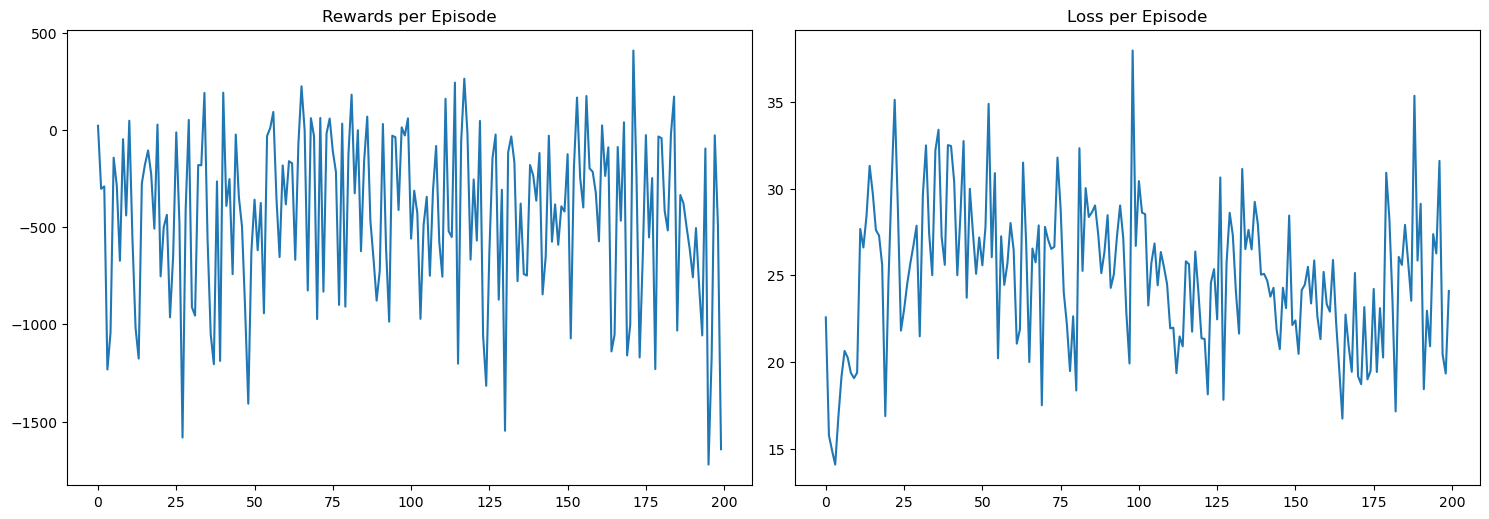

In [ ]:

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(episode_rewards)
plt.title('Rewards per Episode')
plt.subplot(2,2,2)
plt.plot(losses)
plt.title('Loss per Episode')
plt.tight_layout()


In [10]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from env3 import TreasureHuntEnv

# Define custom loss function to match what was used during training
def mse_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

# Create environment with human rendering mode
env = TreasureHuntEnv(size=9, max_steps=500, lives=5, special_duration=20, render_mode='human')

# Load the trained model with custom_objects
model = load_model("treasure_hunt_model.h5", custom_objects={'mse': MeanSquaredError(), 'loss': mse_loss})

def process_observation(obs):
    # Get grid and reshape to 2D to preserve spatial information
    grid = obs['grid'].reshape(env.size, env.size) / 5.0  # Normalize
    
    # Extract agent position and normalize
    agent_x, agent_y = obs['agent_pos']
    norm_x, norm_y = agent_x / env.size, agent_y / env.size
    
    # Additional useful features
    steps_normalized = obs['steps_left'] / env.max_steps
    lives_normalized = obs.get('lives', 3) / 3.0
    special_count = min(len(obs['special_treasures']), 3) / 3.0
    
    # Return the grid and feature vector separately
    return grid, np.array([norm_x, norm_y, steps_normalized, lives_normalized, special_count])

# Run 5 evaluation episodes
num_trials = 5
all_rewards = []
all_steps = []
all_treasures = []
all_special = []

try:
    print("\nStarting evaluation with GUI rendering...")
    print("Press Ctrl+C to stop if needed.")
    
    for trial in range(1, num_trials + 1):
        print(f"\n=== Starting Trial {trial}/{num_trials} ===")
        
        # Reset environment and render initial state
        obs, _ = env.reset()
        env.render()  # Explicitly call render after reset
        time.sleep(0.5)  # Pause to see initial state
        
        state_grid, state_features = process_observation(obs)
        
        done = False
        total_reward = 0
        step_count = 0
        treasures_collected = 0
        special_collected = 0
        
        while not done:
            # Get state representation
            state_grid_batch = state_grid[np.newaxis, :, :]
            state_features_batch = state_features[np.newaxis, :]
            
            # Predict action using model
            q_values = model.predict([state_grid_batch, state_features_batch], verbose=0)[0]
            action = np.argmax(q_values)
            
            # Take action in environment
            next_obs, reward, done, _, info = env.step(action)
            
            # Explicitly render after each step
            env.render()
            
            # Track events
            if 'event' in info:
                if 'treasure_collected' in info['event']:
                    treasures_collected += 1
                    print(f"Step {step_count}: Treasure collected!")
                elif 'special_collected' in info['event']:
                    special_collected += 1
                    print(f"Step {step_count}: Special treasure collected!")
                elif 'trapped' in info['event']:
                    print(f"Step {step_count}: Hit a trap!")
                elif 'caught' in info['event']:
                    print(f"Step {step_count}: Caught by enemy!")
            
            # Update state
            state_grid, state_features = process_observation(next_obs)
            
            # Update counters
            total_reward += reward
            step_count += 1
            
            # Add a delay for better visualization (adjust as needed)
            time.sleep(0.1)
        
        # Record trial statistics
        all_rewards.append(total_reward)
        all_steps.append(step_count)
        all_treasures.append(treasures_collected)
        all_special.append(special_collected)
        
        print(f"\nTrial {trial} Results:")
        print(f"Total reward: {total_reward:.1f}")
        print(f"Steps taken: {step_count}")
        print(f"Treasures collected: {treasures_collected}")
        print(f"Special treasures collected: {special_collected}")
        print("=== Trial Complete ===\n")
        
        # Small delay between trials
        time.sleep(0.5)
    
    # Close environment when done
    env.close()
    
    # Display summary statistics
    print("\n=== Overall Results ===")
    print(f"Average reward: {np.mean(all_rewards):.1f}")
    print(f"Average steps: {np.mean(all_steps):.1f}")
    print(f"Average treasures collected: {np.mean(all_treasures):.1f}")
    print(f"Average special treasures collected: {np.mean(all_special):.1f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.bar(range(1, num_trials + 1), all_rewards)
    plt.title('Rewards per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Total Reward')
    
    plt.subplot(2, 2, 2)
    plt.bar(range(1, num_trials + 1), all_steps)
    plt.title('Steps per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Steps Taken')
    
    plt.subplot(2, 2, 3)
    plt.bar(range(1, num_trials + 1), all_treasures)
    plt.title('Treasures Collected per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 4)
    plt.bar(range(1, num_trials + 1), all_special)
    plt.title('Special Treasures Collected per Trial')
    plt.xlabel('Trial')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('evaluation_results.png')
    plt.show()

except KeyboardInterrupt:
    print("\nEvaluation interrupted by user.")
    env.close()
    
except Exception as e:
    print(f"\nError during evaluation: {e}")
    env.close()


Starting evaluation with GUI rendering...
Press Ctrl+C to stop if needed.

=== Starting Trial 1/5 ===
Step 0: Treasure collected!
Step 4: Treasure collected!
Step 5: Treasure collected!
Step 22: Hit a trap!
Step 24: Hit a trap!
Step 26: Hit a trap!
Step 28: Hit a trap!
Step 30: Hit a trap!
Step 32: Hit a trap!
Step 44: Treasure collected!
Step 45: Treasure collected!
Step 47: Treasure collected!
Step 221: Treasure collected!
Step 271: Special treasure collected!
Step 334: Special treasure collected!
Step 338: Treasure collected!
Step 398: Caught by enemy!
Step 417: Caught by enemy!
Step 455: Caught by enemy!
Step 473: Treasure collected!
Step 475: Hit a trap!
Step 476: Treasure collected!
Step 483: Hit a trap!

Trial 1 Results:
Total reward: -2820.0
Steps taken: 500
Treasures collected: 10
Special treasures collected: 2
=== Trial Complete ===


=== Starting Trial 2/5 ===
Step 0: Treasure collected!
Step 4: Treasure collected!
Step 5: Treasure collected!
Step 123: Treasure collected!
S